# `Промышленное машинное обучение на Spark`
## `Занятие 07: Spark image processing. Spark NLP`

### `Находнов Максим (nakhodnov17@gmail.com)`
#### `Москва, 2023`

О чём можно узнать из этого ноутбука:

* Как загружать изображения в Spark
* Pandas UDF для обработки изображений
* Spark NLP. Предобработка данных, инференс и дообучение глубоких моделей

In [1]:
! pip3 install pyspark pyarrow sparknlp


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
from typing import Iterator

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display

import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

2023-03-13 09:45:42.049677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql.window import Window

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

conf = (
    SparkConf()
        .set('spark.ui.port', '4050')
        .set('spark.driver.memory', '15g')
        .set("spark.kryoserializer.buffer.max", "2000M")
        # Укажем библиотеки, необходимые для Spark NLP
        .set("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:4.3.1")
        .setMaster('local[*]')
)
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

:: loading settings :: url = jar:file:/usr/local/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/nakhodnov/.ivy2/cache
The jars for the packages stored in: /Users/nakhodnov/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-4b2d12fc-501b-4abd-9722-857b0795f565;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.3.1 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.16.0 in central
	found com.google.guava#guava;31.1-jre in central
	found com.google.guav

	0 artifacts copied, 70 already retrieved (0kB/27ms)


23/03/13 09:45:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## `Обработка изображений`

Рассмотрим модельную задачу — классификацию изображений с использованием обученной нейронной сети. 

Её можно разделить на следующие части:
1. Загрузка изображений
2. Предобработка данных. Преобразование в формат, необходимый для подачи в модель
    * Преобразование бинарного формата в объект-изображение
    * Применение операций, специфичных для изображений:
        * Приведение к нужной цветовой модели (обычно RGB[A])
        * Обрезка и масштабирование изображения
    * Преобразование в тензорный формат
    * Нормализация признаков
3. Инференс через модель
4. Отображение результатов

Попробуем реализовать этот пайплайн на примере датасета [ImageNet](https://www.image-net.org/). 

Для демонстрации загрузим небольшую часть этой выборки:

In [ ]:
! wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
! tar -xvf ./imagenette2-320.tgz

In [4]:
! ls imagenette2-320
! ls imagenette2-320/train
! ls imagenette2-320/train/n03394916 | head

noisy_imagenette.csv train                val
n01440764 n02979186 n03028079 n03417042 n03445777
n02102040 n03000684 n03394916 n03425413 n03888257
ILSVRC2012_val_00000957.JPEG
ILSVRC2012_val_00003587.JPEG
ILSVRC2012_val_00003759.JPEG
ILSVRC2012_val_00005548.JPEG
ILSVRC2012_val_00005554.JPEG
ILSVRC2012_val_00007155.JPEG
ILSVRC2012_val_00007536.JPEG
ILSVRC2012_val_00007985.JPEG
ILSVRC2012_val_00009037.JPEG
ILSVRC2012_val_00013113.JPEG
ls: stdout: Broken pipe


|  ![img](imagenette2-320/train/n01440764/ILSVRC2012_val_00007197.JPEG) |  ![img](imagenette2-320/train/n03394916/ILSVRC2012_val_00009037.JPEG)  | ![img](imagenette2-320/train/n02979186/ILSVRC2012_val_00013735.JPEG)   |
|---|---|---|

#### `Загрузка изображений`

Для загрузки изображений необходимо установить формат данных `image`. В таком случае, каждая строка `DataFrame` будет представлять из себя структуру с описанием изображения. При этом, при считывании происходит распаковка сжатых изображений и в `DataFrame` (поле `image.data`) данные хранятся в **RAW** формате (последовательность байтов, описывающая значения пикселей).

In [5]:
# У Spark проблемы с путями, содержащими пробелы — я перенёс изображения в свою корневую директорию
images_dir = "/Users/nakhodnov/imagenette2-320/train/*"

image_df = (
    spark
        .read
        .format("image")
        .load(images_dir)
        .filter("image.nChannels > 2 AND image.height < 1000")
        .limit(20)
        .cache()
)

In [6]:
image_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



Доступ к полям структуры производится через `.`:

In [7]:
image_df.select(
    'image.origin', 
    'image.height', 'image.width', 
    'image.mode', 'image.nChannels'
).show(5, truncate=False)

+----------------------------------------------------------------------------+------+-----+----+---------+
|origin                                                                      |height|width|mode|nChannels|
+----------------------------------------------------------------------------+------+-----+----+---------+
|file:///Users/nakhodnov/imagenette2-320/train/n01440764/n01440764_898.JPEG  |320   |632  |16  |3        |
|file:///Users/nakhodnov/imagenette2-320/train/n03445777/n03445777_3168.JPEG |320   |484  |16  |3        |
|file:///Users/nakhodnov/imagenette2-320/train/n03000684/n03000684_1126.JPEG |320   |829  |16  |3        |
|file:///Users/nakhodnov/imagenette2-320/train/n03028079/n03028079_39986.JPEG|431   |320  |16  |3        |
|file:///Users/nakhodnov/imagenette2-320/train/n03000684/n03000684_33268.JPEG|320   |526  |16  |3        |
+----------------------------------------------------------------------------+------+-----+----+---------+
only showing top 5 rows



In [8]:
[[path, data, h, w]] = image_df.select(
    'image.origin', 'image.data', 'image.height', 'image.width'
).take(1)
path, data[:10], h, w

('file:///Users/nakhodnov/imagenette2-320/train/n01440764/n01440764_898.JPEG',
 bytearray(b'\x11$\x11\x00\x08\x00\x00\x0b\x00!'),
 320,
 632)

#### `Предобработка данных`

Выполнять предобработку данных, представленных в бинарном формате, напрямую обычно не возможно. Для применения специфичных операций можно использовать специальные библиотеки.

Изобразим изображение с использованием библиотеки `PIL`. Для этого сконструируем изображение из массива байт:

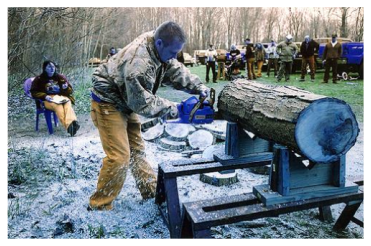

In [9]:
[image_row] = image_df.sample(1e-1, seed=1337).take(1)

color_mode = 'RGBA' if (image_row.image.nChannels == 4) else 'RGB'
image = Image.frombytes(
        mode=color_mode, 
        data=bytes(image_row.image.data), 
        size=[image_row.image.width, image_row.image.height]
)

plt.imshow(image)
plt.axis("off")
plt.show()

Видно, что цветовая схема выбрана неверно. Применим функцию, которое преобразует **BGR $\rightarrow$ RGB**:

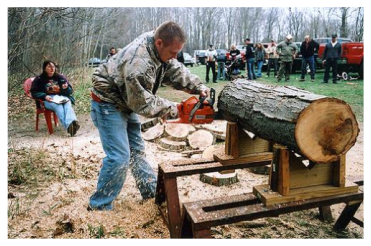

In [10]:
def convert_bgr_to_rgb(image):
    B, G, R = image.T
    return np.array((R, G, B)).T

image_rgb = convert_bgr_to_rgb(np.asarray(image))

plt.imshow(image_rgb)
plt.axis("off")
plt.show()

В дальнейшем, мы хотим использовать обученную нейронную сеть. Обычно, нейросети требуют вход фиксированного размера. Например, сеть [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50) принимает на вход изображение размера $224 \times 224$. 

Как следствие, изображения в датасете нужно привести к необходимому размеру:

In [11]:
def resize_image(image_row, resize=True):
    color_mode = 'RGBA' if (image_row.nChannels == 4) else 'RGB' 
    
    image = Image.frombytes(
        mode=color_mode, data=bytes(image_row.data), size=[image_row.width, image_row.height]
    )
    image = image.convert('RGB') if (color_mode == 'RGBA') else image
    image = image.resize([224, 224], resample=Image.Resampling.BICUBIC) if resize else image
    array = convert_bgr_to_rgb(np.asarray(image)).reshape(-1)
    
    return array

Array shape: (150528,)


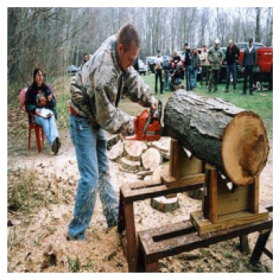

In [12]:
array = resize_image(image_row.image, resize=True)

print('Array shape: {0}'.format(array.shape))

plt.imshow(array.reshape(224, 224, 3))
plt.axis("off")
plt.show()

Теперь применим ко всем изображениям в `DataFrame` нужные преобразования. Для этого реализуем Pandas UDF, которая будет добавлять в `DataFrame` следующие колонки:
* `data_as_array` — RGB изображение в виде плоского массива пикселей
* `data_as_resized_array` — RGB изображение размера 224 x 224 в виде плоского массива пикселей

Рассмотрим два способа применения UDF.

Первый вариант — [mapInPandas](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.mapInPandas.html), позволяет обрабатывать батчи из строк в исходном `DataFrame` в виде `pandas.DataFrame`. Использование итератора позволяет сохранять состояние при обработке разных батчей. В данном примере это не требуется, но во время выполнения инференса такой подход позволит инициализировать модель только один раз на каждом экзекьютере.

In [13]:
# Для определения UDF необходимо явно указать схему DataFrame после преобразования
new_schema = (
    T.StructType(image_df.select("image.*").schema.fields + [
        T.StructField("data_as_array", T.ArrayType(T.IntegerType()), True),
        T.StructField("data_as_resized_array", T.ArrayType(T.IntegerType()), True)
    ])
)

def resize_image_udf(dataframe_batch_iterator: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
    # Используем Iterator Pandas UDF
    for dataframe_batch in dataframe_batch_iterator:
        # Каждую итерацию обрабатывается батч строк из DataFrame, представленный в виде pandas.DataFrame
        dataframe_batch["data_as_array"] = (
            dataframe_batch.apply(resize_image, args=(False,), axis=1)
        )
        dataframe_batch["data_as_resized_array"] = (
            dataframe_batch.apply(resize_image, args=(True,), axis=1)
        )
        
        yield dataframe_batch

resized_df = image_df.select("image.*").mapInPandas(resize_image_udf, new_schema).cache()
resized_df.printSchema()

root
 |-- origin: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- width: integer (nullable = true)
 |-- nChannels: integer (nullable = true)
 |-- mode: integer (nullable = true)
 |-- data: binary (nullable = true)
 |-- data_as_array: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- data_as_resized_array: array (nullable = true)
 |    |-- element: integer (containsNull = true)



Второй вариант — [pandas_udf](https://spark.apache.org/docs/3.1.2/api/python/reference/api/pyspark.sql.functions.pandas_udf.html), а именно Series-to-Series вариант. В этом случае входная колонка также разбивается на батчи строк, которые последовательно передаются в пользовательскую функцию. То есть данный вариант идейно эквивалентен предыдущему, за исключением возможности сохранять внутреннее состояние.

In [14]:
@F.pandas_udf(T.ArrayType(T.IntegerType()))
def image_to_array_udf(images: pd.Series) -> pd.Series:
    return images.apply(resize_image, args=(False,), axis=1)
    
@F.pandas_udf(T.ArrayType(T.IntegerType()))
def resized_image_to_array_udf(images: pd.Series) -> pd.Series:
    return images.apply(resize_image, args=(True,), axis=1)
    
resized_df = (
    image_df
        .withColumn('data_as_array', image_to_array_udf('image'))
        .withColumn('data_as_resized_array', resized_image_to_array_udf('image'))
).cache()
resized_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- data_as_array: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- data_as_resized_array: array (nullable = true)
 |    |-- element: integer (containsNull = true)



Убедимся в корректности преобразований:

In [15]:
[resized_image_row] = resized_df.sample(1e-1, seed=1337).take(1)

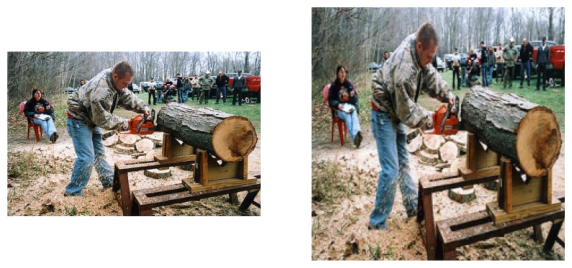

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(
    Image.frombytes(
        mode='RGB', 
        data=bytes(resized_image_row.data_as_array), 
        size=[resized_image_row.image.width, resized_image_row.image.height]
))
axes[1].imshow(
    Image.frombytes(
        mode='RGB', 
        data=bytes(resized_image_row.data_as_resized_array), 
        size=[224, 224]
))
axes[0].axis('off')
axes[1].axis('off')

plt.show()

Теперь, нужно преобразовать изображение в формат, который требует предобученная модель. В данном случае мы можем воспользоваться также готовой функцией:

In [17]:
def normalize_image(image_array):
    return tf.keras.applications.resnet50.preprocess_input(
        image_array.reshape([224, 224, 3])
    )

normalized_input = normalize_image(np.array(resized_image_row.data_as_resized_array))

Проверим, что мы правильно выполнили преобразования и модель, обученная на этом же датасете даёт корректные результаты:

In [18]:
model = ResNet50()

predictions = model.predict(normalized_input[None, ...])

decoded_predictions = tf.keras.applications.resnet50.decode_predictions(predictions, top=5)

predictions[:, :10], decoded_predictions

2023-03-13 09:46:32.491414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 1s 1s/step


(array([[2.4079263e-09, 2.2162289e-10, 9.1816750e-09, 5.5901317e-10,
         1.5636044e-09, 2.2369038e-09, 7.9269541e-10, 1.2373235e-09,
         1.6127216e-09, 8.8182628e-10]], dtype=float32),
 [[('n03000684', 'chain_saw', 0.94682574),
   ('n03697007', 'lumbermill', 0.053020686),
   ('n02795169', 'barrel', 4.875747e-05),
   ('n03498962', 'hatchet', 2.308305e-05),
   ('n03249569', 'drum', 1.5196295e-05)]])

#### `Инференс`

Выполним предсказания для всех объектов. Так как загрузка модели из чекпоинта для каждого батча приведёт к неприемлемой скорости обработки данных, воспользуемся синтаксисом UDF в формате итераторов:

In [19]:
@F.pandas_udf(T.ArrayType(T.FloatType()))
def predict_batch_udf(iterator: Iterator[pd.Series]) -> Iterator[pd.Series]:
    model = ResNet50()
    
    for input_array in iterator:
        normalized_input = np.stack(input_array.map(normalize_image))
        predictions = model.predict(normalized_input)
        yield pd.Series(list(predictions))

predicted_df = resized_df.withColumn(
    "predictions", predict_batch_udf("data_as_resized_array")
)
predicted_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- data_as_array: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- data_as_resized_array: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- predictions: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [20]:
[prediction_row] = predicted_df.sample(1e-1, seed=1337).take(1)

2023-03-13 09:46:36.880287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 09:46:44.276321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
1/1 [==============================] - 2s 2s/step


In [21]:
prediction_row.predictions[:10]

[2.407912536028789e-09,
 2.2162162383043693e-10,
 9.181621685172559e-09,
 5.59009949441247e-10,
 1.5635953642956224e-09,
 2.236890894735666e-09,
 7.926909129096771e-10,
 1.2373163604806336e-09,
 1.6127124080611566e-09,
 8.818212271499704e-10]

Наконец, выведем названия top-5 предсказанных классов:

In [22]:
def get_top5_predictions(predictions):
    return tf.keras.applications.resnet50.decode_predictions(
        np.array(predictions).reshape(1, 1000), top=5
    )

top5_predictions = get_top5_predictions(prediction_row.predictions)
[top5] = top5_predictions

In [23]:
top5

[('n03000684', 'chain_saw', 0.9468257427215576),
 ('n03697007', 'lumbermill', 0.05302068591117859),
 ('n02795169', 'barrel', 4.8757145123090595e-05),
 ('n03498962', 'hatchet', 2.308294097019825e-05),
 ('n03249569', 'drum', 1.5196236745396163e-05)]

Добавим информацию о метках классов в DataFrame. Для этого к каждой строке добавим три колонки в следующем формате:

In [24]:
pd.DataFrame(
    top5, columns=["pred_id", "label", "score"]
).aggregate(lambda x: [x.tolist()], axis=0) 

pred_id  \
0  [n03000684, n03697007, n02795169, n03498962, n...   

                                            label  \
0  [chain_saw, lumbermill, barrel, hatchet, drum]   

                                               score  
0  [0.9468257427215576, 0.05302068591117859, 4.87...

In [25]:
# Указываем, что после обработки будет добавлено три колонки
decoded_predictions_schema = (
    T.StructType(predicted_df.select('image.*', 'data_as_resized_array', 'predictions').schema.fields + [
        T.StructField('pred_id', T.ArrayType(T.StringType()), False),
        T.StructField('label', T.ArrayType(T.StringType()), False),
        T.StructField('score', T.ArrayType(T.FloatType()), False)
]))

def top5predictions_batch_udf(iterator: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
    # Для каждого батча строк добавляем соответствующие колонки
    for dataframe_batch in iterator:
        # Новые колонки для батча
        new_columns = pd.concat([
            # Новые колонки для одной строки в батче
            pd.DataFrame(
                top5, 
                columns=['pred_id', 'label', 'score']
            ).aggregate(lambda x: [x.tolist()], axis=0) 
            for [top5] in dataframe_batch.predictions.map(get_top5_predictions)
        ]).reset_index(drop=True)

        # Добавляем колонки
        yield pd.merge(
            dataframe_batch, right=new_columns,
            left_index=True, right_index=True
        )

# Если используется Arrow формат передачи данных (что необходимо для эффективной работы UDF)
#    то все вложенные структуры необходимо распаковать
top5_predictions_df = predicted_df.select('image.*', 'data_as_resized_array', 'predictions').mapInPandas(
    top5predictions_batch_udf, decoded_predictions_schema
)
top5_predictions_df.printSchema()

root
 |-- origin: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- width: integer (nullable = true)
 |-- nChannels: integer (nullable = true)
 |-- mode: integer (nullable = true)
 |-- data: binary (nullable = true)
 |-- data_as_resized_array: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- predictions: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- pred_id: array (nullable = false)
 |    |-- element: string (containsNull = true)
 |-- label: array (nullable = false)
 |    |-- element: string (containsNull = true)
 |-- score: array (nullable = false)
 |    |-- element: float (containsNull = true)



In [26]:
[top5_prediction_row] = top5_predictions_df.sample(1e-1, seed=1337).take(1)

2023-03-13 09:46:50.924666: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 09:46:58.466820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
1/1 [==============================] - 2s 2s/step
2023-03-13 09:47:04.386488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them i

In [27]:
top5_prediction_row.pred_id, top5_prediction_row.label, top5_prediction_row.score

(['n03000684', 'n03697007', 'n02795169', 'n03498962', 'n03249569'],
 ['chain_saw', 'lumbermill', 'barrel', 'hatchet', 'drum'],
 [0.9468257427215576,
  0.05302068591117859,
  4.8757145123090595e-05,
  2.308294097019825e-05,
  1.5196236745396163e-05])

In [28]:
final_predictions = top5_predictions_df.collect()

1/1 [==============================] - 2s 2s/step                   (0 + 1) / 1]
2023-03-13 09:47:18.200413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
final_predictions[4].pred_id, final_predictions[4].score, final_predictions[4].label

(['n04458633', 'n03697007', 'n03967562', 'n03000684', 'n02879718'],
 [0.27734848856925964,
  0.1470756232738495,
  0.12629401683807373,
  0.09268586337566376,
  0.04072996973991394],
 ['totem_pole', 'lumbermill', 'plow', 'chain_saw', 'bow'])

Изобразим результаты:

In [30]:
fig, axes = plt.subplots(len(final_predictions) // 4, 4, figsize=(2.5 * 4, 2.5 * len(final_predictions) // 4))

for ax, row in zip(axes.reshape(-1), final_predictions):
    image = Image.frombytes(
        mode='RGB', 
        data=bytes(row.data_as_resized_array), 
        size=[224,224]
    )
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(row.label[0])
    
fig.tight_layout()
plt.show()

## `Обработка текстов. Spark NLP`

In [31]:
import sparknlp

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Теперь рассмотрим другой популярный домен — тексты.

Для работы с текстами можно использовать Spark ML, однако, набор средств ограничен. В частности, отсутствуют предобученные модели, включая нейросети. 

**Spark NLP** поддерживает большое чисто трансформеров и эстиматоров для работы с текстами, включая предобученные нейронные сети.

Пайплайн работы с текстами может выглядеть следующим образом:
1. Загрузка данных в Spark DataFrame
2. Преобразование в необходимый для **Spark NLP** тип данных (Document)
3. Преобразования с использованием **Spark NLP** (токенизация, стемминг, эмбеддинги, инференс моделей)
4. Обратное преобразование к "обычные" типы данных
5. Применение Spark ML

Из преимуществ можно отметить высокую эффективность инференса при наличии большого числа экзекьютеров.

Так, при правильной конфигурации Spark NLP может обгонять в $5$ раз GPU:

```text
https://github.com/JohnSnowLabs/spark-nlp/issues/570

For BertEmbeddings:
On a local server with 50 cores and 180G memory:
1. 14k sentences take more than 16000 seconds on CPU (27 minutes)
2. 14K sentences take around 500 seconds on Tesla P100 GPU (less than 10)
3. 17K sentences take around 120 seconds on a CPU-based Spark cluster with 10 executors each 5 cores!
This has been tested on a Bert Model with 256 max sentence length and second-to-last-hidden layer which is way slower due to encoding from sentence's context.

Two things are very important, first is that Bert is GPU optimized not CPU. The second is, we distribute TensorFlow over Spark so this boost parallelism into prediction which as you can see it beats a single GPU. (now if you have GPU Spark cluster then this would be flying)
```

Из недостатков можно отметить, что обучение моделей происходит только на драйвере:
```text
https://github.com/JohnSnowLabs/spark-nlp/issues/9266

* Unfortunately, at the moment the trainable annotators can only use Driver and cannot scale (CPU or GPU).
* Training in Spark NLP happens inside Driver and only on 1 GPU
* Prediction/inference also uses 1 GPU device, however, if you are in a cluster mode (multiple executors) then each machine can have 1 GPU device and that way you can distribute and parallelize the computation over multiple GPU
* Currently, due to TensorFlow limitations especially available APIs in Java only 1 GPU per machine is possible
```

### `Применение готового пайплайна`

Модели можно инферить как для единичных примеров:

In [32]:
from sparknlp.pretrained import PretrainedPipeline

explain_document_pipeline = PretrainedPipeline("explain_document_ml")
annotations = explain_document_pipeline.annotate("We are very happy about SparkNLP")
annotations

explain_document_ml download started this may take some time.
Approx size to download 9,2 MB
[ | ]explain_document_ml download started this may take some time.
Approximate size to download 9,2 MB
Download done! Loading the resource.
[ / ]


[Stage 25:====================================>                   (13 + 7) / 20]



[ \ ]


[ | ]

[OK!]


{'document': ['We are very happy about SparkNLP'],
 'spell': ['We', 'are', 'very', 'happy', 'about', 'SparkNLP'],
 'pos': ['PRP', 'VBP', 'RB', 'JJ', 'IN', 'NNP'],
 'lemmas': ['We', 'be', 'very', 'happy', 'about', 'SparkNLP'],
 'token': ['We', 'are', 'very', 'happy', 'about', 'SparkNLP'],
 'stems': ['we', 'ar', 'veri', 'happi', 'about', 'sparknlp'],
 'sentence': ['We are very happy about SparkNLP']}

Так и для распределённых данных:

In [33]:
sample_df = spark.createDataFrame([
       ("We are very happy about SparkNLP", )
], ['text'])
sample_df.show()

+--------------------+
|                text|
+--------------------+
|We are very happy...|
+--------------------+



In [34]:
explain_document_pipeline.transform(sample_df).toPandas()

23/03/13 09:47:49 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


text  \
0  We are very happy about SparkNLP   

                                            document  \
0  [(document, 0, 31, We are very happy about Spa...   

                                            sentence  \
0  [(document, 0, 31, We are very happy about Spa...   

                                               token  \
0  [(token, 0, 1, We, {'sentence': '0'}, []), (to...   

                                               spell  \
0  [(token, 0, 1, We, {'sentence': '0', 'confiden...   

                                              lemmas  \
0  [(token, 0, 1, We, {'sentence': '0', 'confiden...   

                                               stems  \
0  [(token, 0, 1, we, {'sentence': '0', 'confiden...   

                                                 pos  
0  [(pos, 0, 1, PRP, {'sentence': '0', 'word': 'W...

Библиотеки использует набор концептов из Spark ML:
* **Annotator Approaches** — `Spark ML Estimator`, то есть модель, которую можно обучить
* **Annotator Models** — `Spark ML Transformer`, то есть обученная модель, которая позволяет добавлять колонки в DataFrame

In [35]:
explain_document_pipeline.model.stages

[document_811d40a38b24,
 SENTENCE_ce56851acebe,
 REGEX_TOKENIZER_946f8b0a6a9a,
 SPELL_79c88338ef12,
 LEMMATIZER_c62ad8f355f9,
 STEMMER_caf11d1f4d0e,
 POS_dbb704204f6f]

Spark NLP работает с колонками в особом формате — в **формате аннотированного текста**. Такой тип определяется как список **аннотаций** (annotation), каждая из которых соответствует некоторой подстроке исходного текста (поля `begin`, `end`) и содержит информацию от типе этого отрезка (`annotatorType`), а также сами аннотации (`result`, `metadata`) и метаинформацию (`metadata`).

In [36]:
sentences = [
  ['Hello, this is an example sentence'],
  ['And this is a second sentence.']
]

data = spark.createDataFrame(sentences).toDF("text")
explained_df = explain_document_pipeline.transform(data)
explained_df.printSchema()

root
 |-- text: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- sentence: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true

Рассмотрим примеры таких аннотированных колонок. 

Первым шагом в работе со Spark NLP является преобразование RAW текста в документ. 

Видно, что документ состоит из одной аннотации:

In [37]:
[document] = explained_df.select('document').take(1)
document

Row(document=[Row(annotatorType='document', begin=0, end=33, result='Hello, this is an example sentence', metadata={'sentence': '0'}, embeddings=[])])

Применение других моделей преобразует одну колонку с аннотациями в другую:

In [38]:
[tokens] = explained_df.select('token').take(1)
[pos_tags] = explained_df.select('pos').take(1)

23/03/13 09:47:53 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB



[Stage 45:>                                                         (0 + 1) / 1]



23/03/13 09:47:54 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB



[Stage 46:>                                                         (0 + 4) / 4]



23/03/13 09:47:54 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


Например, токенизация превратит документ в список токенов:

In [39]:
tokens.token

[Row(annotatorType='token', begin=0, end=4, result='Hello', metadata={'sentence': '0'}, embeddings=[]),
 Row(annotatorType='token', begin=5, end=5, result=',', metadata={'sentence': '0'}, embeddings=[]),
 Row(annotatorType='token', begin=7, end=10, result='this', metadata={'sentence': '0'}, embeddings=[]),
 Row(annotatorType='token', begin=12, end=13, result='is', metadata={'sentence': '0'}, embeddings=[]),
 Row(annotatorType='token', begin=15, end=16, result='an', metadata={'sentence': '0'}, embeddings=[]),
 Row(annotatorType='token', begin=18, end=24, result='example', metadata={'sentence': '0'}, embeddings=[]),
 Row(annotatorType='token', begin=26, end=33, result='sentence', metadata={'sentence': '0'}, embeddings=[])]

Применив затем POS-tagger получим список аннотаций-частей речи к списку токенов:

In [40]:
pos_tags.pos

[Row(annotatorType='pos', begin=0, end=4, result='UH', metadata={'sentence': '0', 'word': 'Hello'}, embeddings=[]),
 Row(annotatorType='pos', begin=5, end=5, result=',', metadata={'sentence': '0', 'word': ','}, embeddings=[]),
 Row(annotatorType='pos', begin=7, end=10, result='DT', metadata={'sentence': '0', 'word': 'this'}, embeddings=[]),
 Row(annotatorType='pos', begin=12, end=13, result='VBZ', metadata={'sentence': '0', 'word': 'is'}, embeddings=[]),
 Row(annotatorType='pos', begin=15, end=16, result='DT', metadata={'sentence': '0', 'word': 'an'}, embeddings=[]),
 Row(annotatorType='pos', begin=18, end=24, result='NN', metadata={'sentence': '0', 'word': 'example'}, embeddings=[]),
 Row(annotatorType='pos', begin=26, end=33, result='NN', metadata={'sentence': '0', 'word': 'sentence'}, embeddings=[])]

In [41]:
with pd.option_context('display.max_colwidth', None):
    display(explained_df.select('document').limit(5).toPandas())
    display(explained_df.select('sentence').limit(5).toPandas())    
    display(explained_df.select('token').limit(5).toPandas())    
    display(explained_df.select('spell').limit(5).toPandas())    
    display(explained_df.select('lemmas').limit(5).toPandas())    
    display(explained_df.select('stems').limit(5).toPandas())    
    display(explained_df.select('pos').limit(5).toPandas())    

document
0  [(document, 0, 33, Hello, this is an example sentence, {'sentence': '0'}, [])]
1      [(document, 0, 29, And this is a second sentence., {'sentence': '0'}, [])]

sentence
0  [(document, 0, 33, Hello, this is an example sentence, {'sentence': '0'}, [])]
1      [(document, 0, 29, And this is a second sentence., {'sentence': '0'}, [])]

token
0  [(token, 0, 4, Hello, {'sentence': '0'}, []), (token, 5, 5, ,, {'sentence': '0'}, []), (token, 7, 10, this, {'sentence': '0'}, []), (token, 12, 13, is, {'sentence': '0'}, []), (token, 15, 16, an, {'sentence': '0'}, []), (token, 18, 24, example, {'sentence': '0'}, []), (token, 26, 33, sentence, {'sentence': '0'}, [])]
1      [(token, 0, 2, And, {'sentence': '0'}, []), (token, 4, 7, this, {'sentence': '0'}, []), (token, 9, 10, is, {'sentence': '0'}, []), (token, 12, 12, a, {'sentence': '0'}, []), (token, 14, 19, second, {'sentence': '0'}, []), (token, 21, 28, sentence, {'sentence': '0'}, []), (token, 29, 29, ., {'sentence': '0'}, [])]

23/03/13 09:47:57 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB



[Stage 57:>                                                         (0 + 1) / 1]



23/03/13 09:47:58 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


23/03/13 09:47:59 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


spell
0  [(token, 0, 4, Hello, {'sentence': '0', 'confidence': '1.0'}, []), (token, 5, 5, ,, {'sentence': '0', 'confidence': '0.0'}, []), (token, 7, 10, this, {'sentence': '0', 'confidence': '1.0'}, []), (token, 12, 13, is, {'sentence': '0', 'confidence': '1.0'}, []), (token, 15, 16, an, {'sentence': '0', 'confidence': '1.0'}, []), (token, 18, 24, example, {'sentence': '0', 'confidence': '1.0'}, []), (token, 26, 33, sentence, {'sentence': '0', 'confidence': '1.0'}, [])]
1      [(token, 0, 2, And, {'sentence': '0', 'confidence': '1.0'}, []), (token, 4, 7, this, {'sentence': '0', 'confidence': '1.0'}, []), (token, 9, 10, is, {'sentence': '0', 'confidence': '1.0'}, []), (token, 12, 12, a, {'sentence': '0', 'confidence': '1.0'}, []), (token, 14, 19, second, {'sentence': '0', 'confidence': '1.0'}, []), (token, 21, 28, sentence, {'sentence': '0', 'confidence': '1.0'}, []), (token, 29, 29, ., {'sentence': '0', 'confidence': '0.0'}, [])]

23/03/13 09:48:00 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB



[Stage 60:>                                                         (0 + 1) / 1]



23/03/13 09:48:01 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB



[Stage 61:>                                                         (0 + 4) / 4]



23/03/13 09:48:01 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB



[Stage 62:>                                                         (0 + 7) / 7]



lemmas
0  [(token, 0, 4, Hello, {'sentence': '0', 'confidence': '1.0'}, []), (token, 5, 5, ,, {'sentence': '0', 'confidence': '0.0'}, []), (token, 7, 10, this, {'sentence': '0', 'confidence': '1.0'}, []), (token, 12, 13, be, {'sentence': '0', 'confidence': '1.0'}, []), (token, 15, 16, an, {'sentence': '0', 'confidence': '1.0'}, []), (token, 18, 24, example, {'sentence': '0', 'confidence': '1.0'}, []), (token, 26, 33, sentence, {'sentence': '0', 'confidence': '1.0'}, [])]
1      [(token, 0, 2, And, {'sentence': '0', 'confidence': '1.0'}, []), (token, 4, 7, this, {'sentence': '0', 'confidence': '1.0'}, []), (token, 9, 10, be, {'sentence': '0', 'confidence': '1.0'}, []), (token, 12, 12, a, {'sentence': '0', 'confidence': '1.0'}, []), (token, 14, 19, second, {'sentence': '0', 'confidence': '1.0'}, []), (token, 21, 28, sentence, {'sentence': '0', 'confidence': '1.0'}, []), (token, 29, 29, ., {'sentence': '0', 'confidence': '0.0'}, [])]

23/03/13 09:48:02 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB



[Stage 63:>                                                         (0 + 1) / 1]



23/03/13 09:48:03 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB



[Stage 64:>                                                         (0 + 4) / 4]



23/03/13 09:48:03 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


stems
0  [(token, 0, 4, hello, {'sentence': '0', 'confidence': '1.0'}, []), (token, 5, 5, ,, {'sentence': '0', 'confidence': '0.0'}, []), (token, 7, 10, thi, {'sentence': '0', 'confidence': '1.0'}, []), (token, 12, 13, i, {'sentence': '0', 'confidence': '1.0'}, []), (token, 15, 16, an, {'sentence': '0', 'confidence': '1.0'}, []), (token, 18, 24, exampl, {'sentence': '0', 'confidence': '1.0'}, []), (token, 26, 33, sentenc, {'sentence': '0', 'confidence': '1.0'}, [])]
1     [(token, 0, 2, and, {'sentence': '0', 'confidence': '1.0'}, []), (token, 4, 7, thi, {'sentence': '0', 'confidence': '1.0'}, []), (token, 9, 10, i, {'sentence': '0', 'confidence': '1.0'}, []), (token, 12, 12, a, {'sentence': '0', 'confidence': '1.0'}, []), (token, 14, 19, second, {'sentence': '0', 'confidence': '1.0'}, []), (token, 21, 28, sentenc, {'sentence': '0', 'confidence': '1.0'}, []), (token, 29, 29, ., {'sentence': '0', 'confidence': '0.0'}, [])]

23/03/13 09:48:05 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/03/13 09:48:06 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB



[Stage 67:>                                                         (0 + 4) / 4]



23/03/13 09:48:06 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


pos
0  [(pos, 0, 4, UH, {'sentence': '0', 'word': 'Hello'}, []), (pos, 5, 5, ,, {'sentence': '0', 'word': ','}, []), (pos, 7, 10, DT, {'sentence': '0', 'word': 'this'}, []), (pos, 12, 13, VBZ, {'sentence': '0', 'word': 'is'}, []), (pos, 15, 16, DT, {'sentence': '0', 'word': 'an'}, []), (pos, 18, 24, NN, {'sentence': '0', 'word': 'example'}, []), (pos, 26, 33, NN, {'sentence': '0', 'word': 'sentence'}, [])]
1      [(pos, 0, 2, CC, {'sentence': '0', 'word': 'And'}, []), (pos, 4, 7, DT, {'sentence': '0', 'word': 'this'}, []), (pos, 9, 10, VBZ, {'sentence': '0', 'word': 'is'}, []), (pos, 12, 12, DT, {'sentence': '0', 'word': 'a'}, []), (pos, 14, 19, JJ, {'sentence': '0', 'word': 'second'}, []), (pos, 21, 28, NN, {'sentence': '0', 'word': 'sentence'}, []), (pos, 29, 29, ., {'sentence': '0', 'word': '.'}, [])]

Вывод колонок в виде аннотаций затрудняет анализ данных. Для удобного чтения содержимого используется Transformer `sparknlp.Finisher`, который оставляет только поле `result` из каждой аннотации и возвращает их в виде списка:

In [42]:
finisher = sparknlp.Finisher().setInputCols(["token", "lemmas", "pos"])

pipeline = (
    Pipeline()
        .setStages([
            explain_document_pipeline.model,
            finisher
        ])
)

model = pipeline.fit(data)

annotations_finished_df = model.transform(data)

with pd.option_context('display.max_colwidth', None):
    display(annotations_finished_df.select('text').limit(5).toPandas())
    display(annotations_finished_df.select('finished_pos').limit(5).toPandas())
    display(annotations_finished_df.select('finished_token').limit(5).toPandas())
    display(annotations_finished_df.select('finished_lemmas').limit(5).toPandas())

text
0  Hello, this is an example sentence
1      And this is a second sentence.

23/03/13 09:48:08 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/03/13 09:48:09 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/03/13 09:48:09 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


finished_pos
0  [UH, ,, DT, VBZ, DT, NN, NN]
1  [CC, DT, VBZ, DT, JJ, NN, .]

finished_token
0  [Hello, ,, this, is, an, example, sentence]
1      [And, this, is, a, second, sentence, .]

23/03/13 09:48:11 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB



[Stage 78:>                                                         (0 + 1) / 1]



23/03/13 09:48:11 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB



[Stage 79:>                                                         (0 + 4) / 4]



23/03/13 09:48:12 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


finished_lemmas
0  [Hello, ,, this, be, an, example, sentence]
1      [And, this, be, a, second, sentence, .]

### `Дообучение классификатора`

Применим Spark NLP для дообучения на задаче многоклассовой классификации — будем предсказывать категорию новостей:

In [43]:
base_url = 'https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/news_Category'
! wget -O news_category_test.csv $base_url/news_category_test.csv
! wget -O news_category_train.csv $base_url/news_category_train.csv

--2023-03-13 09:48:13--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/news_Category/news_category_test.csv
Распознаётся s3.amazonaws.com (s3.amazonaws.com)… 52.216.49.208, 52.217.90.206, 52.216.77.166, ...
Подключение к s3.amazonaws.com (s3.amazonaws.com)|52.216.49.208|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 1504408 (1,4M) [text/csv]
Сохранение в: «news_category_test.csv»

news_category_test. 100%[===================>]   1,43M  1,89MB/s    за 0,8s    

2023-03-13 09:48:15 (1,89 MB/s) - «news_category_test.csv» сохранён [1504408/1504408]

--2023-03-13 09:48:15--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/news_Category/news_category_train.csv
Распознаётся s3.amazonaws.com (s3.amazonaws.com)… 52.216.99.85, 52.217.90.206, 52.216.77.166, ...
Подключение к s3.amazonaws.com (s3.amazonaws.com)|52.216.99.85|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание

In [44]:
! head news_category_train.csv

category,description
Business," Short sellers, Wall Street's dwindling band of ultra cynics, are seeing green again."
Business," Private investment firm Carlyle Group, which has a reputation for making well timed and occasionally controversial plays in the defense industry, has quietly placed its bets on another part of the market."
Business, Soaring crude prices plus worries about the economy and the outlook for earnings are expected to hang over the stock market next week during the depth of the summer doldrums.
Business," Authorities have halted oil export flows from the main pipeline in southern Iraq after intelligence showed a rebel militia could strike infrastructure, an oil official said on Saturday."
Business," Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections."
Business," Stocks ended slightly higher on Friday but stayed near lows for the year as oil prices surged past  #36;

In [45]:
train_df = (
    spark.read
      .option("header", True)
      .csv("news_category_train.csv")
)
test_df = (
    spark.read
      .option("header", True)
      .csv("news_category_test.csv")
)

display(train_df.limit(5).toPandas())
display(test_df.limit(5).toPandas())

train_df.count(), test_df.count()

category                                        description
0  Business   Short sellers, Wall Street's dwindling band o...
1  Business   Private investment firm Carlyle Group, which ...
2  Business   Soaring crude prices plus worries about the e...
3  Business   Authorities have halted oil export flows from...
4  Business   Tearaway world oil prices, toppling records a...

category                                        description
0  Business  Unions representing workers at Turner   Newall...
1  Sci/Tech   TORONTO, Canada    A second team of rocketeer...
2  Sci/Tech   A company founded by a chemistry researcher a...
3  Sci/Tech   It's barely dawn when Mike Fitzpatrick starts...
4  Sci/Tech   Southern California's smog fighting agency we...

(120000, 7600)

Создадим пайплайн:
1. Преобразование **RAW** текста в аннотированный формат (документ)
2. Вычисление эмбеддингов предложений
3. Дообучение классификатора

In [46]:
document = (
    sparknlp.base.DocumentAssembler()
        .setInputCol("description")
        .setOutputCol("document")
)

use = (
    sparknlp.annotator.UniversalSentenceEncoder.pretrained()
     .setInputCols(["document"])
     .setOutputCol("sentence_embeddings")
)

classsifierdl = (
    sparknlp.annotator.ClassifierDLApproach()
      .setInputCols(["sentence_embeddings"])
      .setOutputCol("class")
      .setLabelColumn("category")
      .setMaxEpochs(5)
      .setEnableOutputLogs(True)
)

dl_pipeline = Pipeline(stages=[
    document,
    use,
    classsifierdl
])

tfhub_use download started this may take some time.
Approximate size to download 923,7 MB
[ | ]tfhub_use download started this may take some time.
Approximate size to download 923,7 MB
[ | ]Download done! Loading the resource.
[ \ ]

2023-03-13 09:48:51.956049: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[OK!]


In [47]:
dl_pipeline_model = dl_pipeline.fit(train_df)

2023-03-13 09:49:51.656389: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/3c/vr2463p11lz5fr_80mrg72gh0000gq/T/e5b019cf3fec_classifier_dl16925895798860295461
2023-03-13 09:49:51.722592: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2023-03-13 09:49:51.722635: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /var/folders/3c/vr2463p11lz5fr_80mrg72gh0000gq/T/e5b019cf3fec_classifier_dl16925895798860295461
2023-03-13 09:49:52.104060: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-03-13 09:49:53.050622: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /var/folders/3c/vr2463p11lz5fr_80mrg72gh0000gq/T/e5b019cf3fec_classifier_dl16925895798860295461
2023-03-13 09:49:53.180134: I external/o

Training started - epochs: 5 - learning_rate: 0.005 - batch_size: 64 - training_examples: 120000 - classes: 4
Epoch 1/5 - 23,39s - loss: 1606.1649 - acc: 0.8805917 - batches: 1875
Epoch 2/5 - 29,09s - loss: 1584.7252 - acc: 0.89276665 - batches: 1875
Epoch 3/5 - 30,63s - loss: 1578.5599 - acc: 0.8979 - batches: 1875
Epoch 4/5 - 34,19s - loss: 1573.5647 - acc: 0.90124166 - batches: 1875
Epoch 5/5 - 34,92s - loss: 1569.5552 - acc: 0.90445834 - batches: 1875


Обученные модели можно сохранять и загружать:

In [48]:
dl_pipeline_model.stages[-1].write().overwrite().save('./tmp_classifierDL_model')

In [49]:
classsifierdl_loaded = (
    sparknlp.annotator.ClassifierDLModel.load("./tmp_classifierDL_model")
      .setInputCols(["sentence_embeddings"])
      .setOutputCol("class")
)

dl_pipeline_eval = Pipeline(stages=[
    document,
    use,
    classsifierdl_loaded
])

Применим получившуюся модель для тестовых данных:

In [50]:
test_df_sample = spark.createDataFrame([
    "Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.",
    "Scientists have discovered irregular lumps beneath the icy surface of Jupiter's largest moon, Ganymede. These irregular masses may be rock formations, supported by Ganymede's icy shell for btest_dfions of years..."
], T.StringType()).toDF("description")

prediction = dl_pipeline_eval.fit(test_df_sample).transform(test_df_sample)

prediction.printSchema()
prediction.select('class.result').show()
prediction.select('class.metadata').show(truncate=False)

root
 |-- description: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- sentence_embeddings: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueC

+----------+
|    result|
+----------+
|[Business]|
|[Sci/Tech]|
+----------+

+----------------------------------------------------------------------------------------------------------------+
|metadata                                                                                                        |
+----------------------------------------------------------------------------------------------------------------+
|[{Sports -> 9.426828E-7, Business -> 0.9999814, World -> 1.2755756E-5, Sci/Tech -> 4.9103824E-6, sentence -> 0}]|
|[{Sports -> 1.1566791E-16, Business -> 1.405971E-16, World -> 1.2799754E-16, Sci/Tech -> 1.0, sentence -> 0}]   |
+----------------------------------------------------------------------------------------------------------------+



In [51]:
predictions = dl_pipeline_eval.fit(test_df).transform(test_df)
predictions.select('category', 'description', 'class.result').sample(0.01).show(10, truncate=50)

+--------+--------------------------------------------------+----------+
|category|                                       description|    result|
+--------+--------------------------------------------------+----------+
|Sci/Tech|Government in South Indian state of Kerala sets...|[Sci/Tech]|
|  Sports|Athens, Greece (Sports Network) - Wednesday nig...|  [Sports]|
|Business|Tertiary index comes in at almost double expect...|[Business]|
|   World|Labor members have scheduled two  #39;rebel #39...|   [World]|
|Business| New Zealand #39;s Auckland International Airpo...|[Business]|
|   World|THE Thatcher saga took a dramatic twist last ni...|   [World]|
|Sci/Tech|"Personal computer giant Hewlett-Packard Co. is...|[Sci/Tech]|
|   World|Shaukat Aziz, taking over as Pakistan #39;s 23r...|   [World]|
|   World| Saboteurs blew up a pipeline in southern Iraq ...|   [World]|
|   World|A Pakistani Foreign Office spokesman Sunday sai...|   [World]|
+--------+-----------------------------------------

### `Оценка качества`

Оценим качество получившейся модели, посчитав Accuracy.

Это можно сделать двумя путями:
1. Посчитать Accuracy вручную
2. Использовать `MulticlassClassificationEvaluator`

Сделаем это обоими методами.

Оставим только нужные колонки для удобства. Также, преобразуем колонку с предсказанием. `class.result` — список из одного элемента. `F.explode` позволяет его распаковать. Как альтернативу, можно использовать `F.element_at(F.col('class.result'), 1)`:

In [52]:
predictions = predictions.select('category', 'description', F.explode('class.result').alias('prediction'))
predictions.show(10)

+--------+--------------------+----------+
|category|         description|prediction|
+--------+--------------------+----------+
|Business|Unions representi...|  Business|
|Sci/Tech| TORONTO, Canada ...|  Sci/Tech|
|Sci/Tech| A company founde...|  Sci/Tech|
|Sci/Tech| It's barely dawn...|  Sci/Tech|
|Sci/Tech| Southern Califor...|  Sci/Tech|
|Sci/Tech|"The British Depa...|     World|
|Sci/Tech|"confessed author...|  Sci/Tech|
|Sci/Tech|\\FOAF/LOAF  and ...|  Sci/Tech|
|Sci/Tech|"Wiltshire Police...|  Sci/Tech|
|Sci/Tech|In its first two ...|  Sci/Tech|
+--------+--------------------+----------+
only showing top 10 rows



#### `1`

In [53]:
(
    predictions
        .select(F.mean(
            # Для агрегации усреднением нужно выполнить преобразование к вещественному типу
            (F.col('category') == F.col('prediction')).cast(T.FloatType())
        ).alias('accuracy'))
).show()

+------------------+
|          accuracy|
+------------------+
|0.8939473684210526|
+------------------+



#### `2`

`MulticlassClassificationEvaluator` требует колонки вещественного типа, поэтому нам нужно предварительно выполнить кодирование названий категорий в индексы. Один из вариантов это сделать: `join` с таблицей, в которой хранится это соответствие.

Такую табличку можно сделать множеством вариантов. Вот несколько из них:

In [54]:
# Сложный вариант, но полезный, когда классов много и нужно выполнить детерминированное кодирование (за счёт сортировки)
# Для этого сначала категории уникуются, затем устанавливается соответствие, нумеруя с 1 
wspec = Window().partitionBy().orderBy('category')
label_to_idx = (
    train_df
        .select('category')
        .distinct()
        .select(F.col('category').alias('label'), F.row_number().over(wspec).alias('idx'))
)
label_to_idx.show()

23/03/13 09:52:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/13 09:52:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/13 09:52:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/13 09:52:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/13 09:52:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/13 09:52:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+--------+

In [55]:
# Чуть проще, но отсутствует детерминированность
label_to_idx = (
    train_df
        .select('category')
        .distinct()
        .select(F.col('category').alias('label'), F.monotonically_increasing_id().alias('idx'))
)
label_to_idx.show()

# Результат будет зависеть от того, сколько на сколько партиций разбит данный RDD
label_to_idx = (
    train_df
        .select('category')
        .distinct()
        .repartition(2)
        .select(F.col('category').alias('label'), F.monotonically_increasing_id().alias('idx'))
)
label_to_idx.show()

+--------+---+
|   label|idx|
+--------+---+
|   World|  0|
|Sci/Tech|  1|
|  Sports|  2|
|Business|  3|
+--------+---+

+--------+----------+
|   label|       idx|
+--------+----------+
|   World|         0|
|Business|         1|
|Sci/Tech|8589934592|
|  Sports|8589934593|
+--------+----------+



In [56]:
# Самый простой вариант — закодировать числа вручную,
#   однако есть шанс ошибиться, особенно есть используются Unicode строки
label_to_idx = spark.createDataFrame([
    ('Business', 1),
    ('Sci/Tech', 2),
    ('Sports',   3),
    ('World',   4),
], ['label', 'idx'])
label_to_idx.show()

+--------+---+
|   label|idx|
+--------+---+
|Business|  1|
|Sci/Tech|  2|
|  Sports|  3|
|   World|  4|
+--------+---+



Так как `label_to_idx` маленького размера, то желательно использовать broadcast join:

In [57]:
predictions_with_idx = (
    predictions
        .join(
            F.broadcast(label_to_idx).withColumnRenamed('idx', 'category_idx'), 
            on=predictions.category == label_to_idx.label
        )
        .drop('label')
        .join(
            F.broadcast(label_to_idx).withColumnRenamed('idx', 'prediction_idx'), 
            on=F.col('prediction') == label_to_idx.label
        )
        .drop('label')
)
predictions_with_idx.show(10)

+--------+--------------------+----------+------------+--------------+
|category|         description|prediction|category_idx|prediction_idx|
+--------+--------------------+----------+------------+--------------+
|Business|Unions representi...|  Business|           1|             1|
|Sci/Tech| TORONTO, Canada ...|  Sci/Tech|           2|             2|
|Sci/Tech| A company founde...|  Sci/Tech|           2|             2|
|Sci/Tech| It's barely dawn...|  Sci/Tech|           2|             2|
|Sci/Tech| Southern Califor...|  Sci/Tech|           2|             2|
|Sci/Tech|"The British Depa...|     World|           2|             4|
|Sci/Tech|"confessed author...|  Sci/Tech|           2|             2|
|Sci/Tech|\\FOAF/LOAF  and ...|  Sci/Tech|           2|             2|
|Sci/Tech|"Wiltshire Police...|  Sci/Tech|           2|             2|
|Sci/Tech|In its first two ...|  Sci/Tech|           2|             2|
+--------+--------------------+----------+------------+--------------+
only s

In [58]:
evaluator = MulticlassClassificationEvaluator(
    predictionCol='prediction_idx', labelCol='category_idx', metricName='accuracy'
)
evaluator.evaluate((
    predictions_with_idx
        .select(
            F.col('category_idx').cast(T.DoubleType()),
            F.col('prediction_idx').cast(T.DoubleType())
        )
))

0.8939473684210526

Ешё один вариант для кодирования строк, который больше подходит по стилю при работы с пайплайнами: `StringIndexer`.

In [59]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol='label', outputCol='idx')
indexer_model = indexer.fit(train_df.withColumnRenamed('category', 'label'))

predictions_with_idx = indexer_model.transform(
    predictions.withColumnRenamed('category', 'label')
).withColumnRenamed('idx', 'category_idx').withColumnRenamed('label', 'category')

predictions_with_idx = indexer_model.transform(
    predictions_with_idx.withColumnRenamed('prediction', 'label')
).withColumnRenamed('idx', 'prediction_idx').withColumnRenamed('label', 'prediction')
predictions_with_idx.show(10)

+--------+--------------------+----------+------------+--------------+
|category|         description|prediction|category_idx|prediction_idx|
+--------+--------------------+----------+------------+--------------+
|Business|Unions representi...|  Business|         0.0|           0.0|
|Sci/Tech| TORONTO, Canada ...|  Sci/Tech|         1.0|           1.0|
|Sci/Tech| A company founde...|  Sci/Tech|         1.0|           1.0|
|Sci/Tech| It's barely dawn...|  Sci/Tech|         1.0|           1.0|
|Sci/Tech| Southern Califor...|  Sci/Tech|         1.0|           1.0|
|Sci/Tech|"The British Depa...|     World|         1.0|           3.0|
|Sci/Tech|"confessed author...|  Sci/Tech|         1.0|           1.0|
|Sci/Tech|\\FOAF/LOAF  and ...|  Sci/Tech|         1.0|           1.0|
|Sci/Tech|"Wiltshire Police...|  Sci/Tech|         1.0|           1.0|
|Sci/Tech|In its first two ...|  Sci/Tech|         1.0|           1.0|
+--------+--------------------+----------+------------+--------------+
only s

Теперь можно применить Evaluator:

In [60]:
evaluator.evaluate(predictions_with_idx)

0.8939473684210526

 ## `Подсчёт RMSSE`

$$
\text{RMSSE} = \sqrt{ \frac{1}{h} \frac{\sum\limits_{t=n+1}^{n+h} (Y_{t} - \hat{Y}_{t})^{2}}{\frac{1}{n - 1}\sum\limits_{t=2}^{n}(Y_{t} - Y_{t-1})^{2}} }
$$

Прочитать про разные метрики можно в [следующей статье](https://arxiv.org/pdf/2203.10716.pdf).

| $t$  | $Y_{t}$  |  $\hat{Y}_{t}$ |
|---|---|---|
| 1 | 1.5 | 1.0 |
| 2 | 0.5 | 2.0 |
| 3 | 1.0 | 4.0 |
| 4 | 2.0 | 5.0 |
| 5 | 7.5 | 6.0 |

$$
n = 3, h = 2 \Longrightarrow \text{RMSSE} = \sqrt{ \frac{1}{2} \frac{((2 - 5)^{2} + (7.5 - 6)^{2})}{ \frac{1}{2} ((0.5-1.5)^{2} + (1-0.5)^{2})} } = \sqrt{ \frac{1}{2} \frac{(9 + 2.25)}{ \frac{1}{2} (1 + 0.25)} } = \sqrt{ \frac{11.25}{1.25}} = 3
$$

In [61]:
df_rmsse = spark.createDataFrame([
    (1, 1.5, 1.0),
    (2, 0.5, 2.0),
    (3, 1.0, 4.0),
    (4, 2.0, 5.0),
    (5, 7.5, 6.0),
], ['day', 'target', 'prediction'])

In [62]:
n, h = 3, 2

wspec = Window().partitionBy().orderBy('day')

[denominator] = (
    df_rmsse
        .where(F.col('day') <= n)
        .select('*', F.lag('target', 1).over(wspec).alias('Y_{t-1}'))
        .select(F.mean(F.pow(F.col('target') - F.col('Y_{t-1}'), 2.0)).alias('denominator'))
        .take(1)
)

[numerator] = (
    df_rmsse
        .where(F.col('day') > n)
        .select(F.mean(F.pow(F.col('target') - F.col('prediction'), 2.0)).alias('numerator'))
        .take(1)
)
np.sqrt(numerator.numerator / denominator.denominator)

23/03/13 09:53:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/13 09:53:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/13 09:53:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/03/13 09:53:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


3.0